<a href="https://colab.research.google.com/github/Mejia2003/InfoII/blob/main/trabajofinal_Modelo_nicolemejia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.io import loadmat


class Doctor:
    def __init__(self, nombre, usuario, contraseña=None):
        self.nombre = nombre
        self.usuario = usuario
        self.contraseña = contraseña

class Paciente:
    def __init__(self, nombre, apellido, edad, genero, identificacion, fecha):
        self.nombre = nombre
        self.apellido = apellido
        self.edad = edad
        self.genero = genero
        self.identificacion = identificacion
        self.fecha = fecha

class SistemaGestionModelo:
    def __init__(self):
        self.doctores = {}
        self.pacientes = {}


    # Funcion guardar_usuario_doctor. Es necesario un condicional para verificar si el usuario del doctor se encuentra dentro de nuestro diccionario
    # Si el usuario ya existe, se lanza un error ValueError indicando que el usuario ya está registrado.
    # La razón de utilizar raise en este contexto es para manejar el caso en el que se intente agregar un usuario que ya está en el diccionario .
    # Si el usuario no existe, se agrega al diccionario con su correspondiente contraseña

    def guardar_usuario_doctor(self, nombre, usuario):
        if usuario in self.doctores:
          raise ValueError("El usuario ya existe.")
        self.doctores[usuario] = Doctor(nombre, usuario)
        print("Doctor agregado exitosamente.")

    def guardar_contraseña_doctor(self, usuario, contraseña):
        if usuario not in self.doctores:
            raise ValueError("El usuario no existe.")
        if not contraseña:
            raise ValueError("La contraseña no puede estar vacía.")

        doctor = self.doctores.get(usuario)
        if not hasattr(doctor, 'contraseña'):
            raise AttributeError(f"El objeto doctor no tiene un atributo 'contraseña'.")

        self.doctores[usuario].contraseña = contraseña


    def guardar_paciente(self, nombre, apellido, edad, genero, identificacion, fecha):
        if identificacion in self.pacientes:
            raise ValueError("El paciente ya existe.")
        self.pacientes[identificacion] = Paciente(nombre, apellido, edad, genero, identificacion, fecha)


    def cargar_ekg(self,fs=1000, f_p=1, f_qrs=0.5, pr_interval_start=0.1, pr_interval_end=0.2):

    #Genera y grafica una señal de EKG simulada con un intervalo PR destacado.

    #Parámetros:
    #fs: Frecuencia de muestreo en Hz (por defecto 1000)
    #f_p: Frecuencia de la onda P en Hz (por defecto 1)
    #f_qrs: Frecuencia del complejo QRS en Hz (por defecto 0.5)
    #pr_interval_start: Inicio del intervalo PR en segundos (por defecto 0.1)
    #pr_interval_end: Fin del intervalo PR en segundos (por defecto 0.2)
    # Generar la señal de EKG simulada
      t = np.linspace(0, 1, fs)  # Tiempo de 0 a 1 segundo
      ecg_signal = (
          np.sin(2*np.pi*f_p*t) +  # Onda P
          np.sin(2*np.pi*f_qrs*t)  # Complejo QRS
      ) * 0.5  # Amplitud reducida para una mejor visualización

    # Graficar la señal de EKG
      plt.figure(figsize=(12, 4))
      plt.plot(t, ecg_signal, color='black', label='Señal de EKG')
      plt.fill_betweenx(
          y=[np.min(ecg_signal), np.max(ecg_signal)],
          x1=pr_interval_start,
          x2=pr_interval_end,
          color='lightblue',
          alpha=0.5,
          label='Intervalo PR'
      )
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Amplitud')
      plt.title('Señal de EKG con Intervalo PR')
      plt.legend()
      plt.grid(True)
      plt.show()

      return ecg_signal, pr_interval_start, pr_interval_end


    def diagnosticar_paciente(self, fs=1000, f_p=1, f_qrs=0.5, pr_interval_start=0.1, pr_interval_end=0.2):
        ecg_signal, pr_start, pr_end = self.cargar_ekg(fs, f_p, f_qrs, pr_interval_start, pr_interval_end)
        pr_duration = pr_end - pr_start

        if pr_duration < 0.20:
            return "Posible bloqueo cardíaco: intervalo PR corto."
        elif pr_duration > 0.20:
            return "Posible bloqueo auriculoventricular: intervalo PR largo."
        else:
            return "Intervalo PR normal."

        if self.detectar_bloqueo_tipo_I(ecg_signal):
          return "Bloqueo AV de primer grado"


        if self.detectar_bloqueo_mobitz_I(ecg_signal):
            return "Bloqueo AV de segundo grado tipo Mobitz I."


        # Detección de bloqueo tipo II Mobitz II
        if self.detectar_bloqueo_mobitz_II(ecg_signal):
            return "Bloqueo AV de segundo grado tipo Mobitz II."


        # Detección de Bloqueo tipo III
        if self.detectar_bloqueo_tipo_III(ecg_signal):
            return "Bloqueo AV de tercer grado (completo)."

        return "Para dar un diagnostico adecuado para el paciente es necesario realizarle mas estudios al paciente, dado a que es inconcluso los resultos."



    def detectar_bloqueo_tipo_I(ecg_signal, fs, pr_threshold=0.20):
    # Duración del intervalo PR en segundos para considerarlo como bloqueo tipo I
      pr_threshold_samples = int(pr_threshold * fs)

    # Buscar intervalos PR mayores al umbral
      pr_duration = 0
      qrs_detected = False
      for sample in ecg_signal:
          if sample == 0 and not qrs_detected:
             pr_duration += 1
          elif sample != 0 and not qrs_detected:
              qrs_detected = True
          elif sample == 0 and qrs_detected:
              if pr_duration > pr_threshold_samples:
                  return True  # Se detectó un posible bloqueo tipo I
              pr_duration = 0
              qrs_detected = False

      return False  # No se detectó bloqueo tipo I



    def detectar_bloqueo_mobitz_I(self, ecg_signal, fs):
        # Duración máxima del intervalo PR para considerarlo como bloqueo Mobitz I
        max_pr_duration = 0.20 * fs  # Convertir de segundos a muestras

        # Buscar el alargamiento progresivo del intervalo PR y la desaparición del complejo QRS
        pr_intervals = []
        qrs_detected = False
        for i, sample in enumerate(ecg_signal):
            if sample == 0 and not qrs_detected:
                continue  # Evitar falsas detecciones
            elif sample != 0 and not qrs_detected:
                qrs_detected = True
            elif sample == 0 and qrs_detected:
                pr_intervals.append(i)
                qrs_detected = False

        # Calcular la duración de los intervalos PR y verificar si hay bloqueo Mobitz I
        for i in range(len(pr_intervals) - 1):
            pr_duration = pr_intervals[i + 1] - pr_intervals[i]
            if pr_duration > max_pr_duration:
                return True  # Se detectó un posible bloqueo Mobitz I

        return False  # No se detectó bloqueo Mobitz I

    def detectar_bloqueo_mobitz_II(self, ecg_signal):
        p_wave_count = 0  # Contador de ondas P
        qrs_detected = False  # Indicador de detección de complejo QRS
        pr_intervals = []  # Lista para almacenar los intervalos PR

        # Buscar las características del bloqueo Mobitz II
        for sample in ecg_signal:
            if sample == 0 and not qrs_detected:
                continue  # Evitar falsas detecciones
            elif sample != 0 and not qrs_detected:
                qrs_detected = True
            elif sample == 0 and qrs_detected:
                p_wave_count += 1
                qrs_detected = False
            elif sample != 0 and qrs_detected:
                pr_intervals.append(p_wave_count)
                p_wave_count = 0

        # Verificar si se cumplen las condiciones del bloqueo Mobitz II
        if len(pr_intervals) > 2:
            return True  # Se detectó un posible bloqueo Mobitz II

        return False  # No se detectó bloqueo Mobitz II

    def detectar_bloqueo_tipo_III(self, ecg_signal):
        p_wave_detected = False  # Indicador de detección de onda P
        qrs_detected = False  # Indicador de detección de complejo QRS

        # Buscar la disociación entre las ondas P y los complejos QRS
        for sample in ecg_signal:
            if sample == 0 and not qrs_detected:
                continue  # Evitar falsas detecciones
            elif sample != 0 and not qrs_detected:
                qrs_detected = True
            elif sample == 0 and qrs_detected:
                p_wave_detected = True
            elif sample != 0 and qrs_detected and p_wave_detected:
                return True  # Se detectó un posible bloqueo AV tipo III

        return False  # No se detectó bloqueo AV tipo III

    def variar_amplitud_ekg(self, señal, factor_amplitud):
        return [punto * factor_amplitud for punto in señal]

    def variar_frec_ekg(self, señal, factor_frecuencia):
        if not isinstance(factor_frecuencia, (int, float)) or factor_frecuencia <= 0:
            raise ValueError("Factor de frecuencia debe ser un número positivo.")
        num_muestras = int(len(señal) * factor_frecuencia)
        señal_resampleada = np.interp(np.linspace(0, len(señal) - 1, num_muestras), np.arange(len(señal)), señal)
        return señal_resampleada



In [29]:
sistema = SistemaGestionModelo()

In [31]:
try:
    sistema.guardar_usuario_doctor("Dr. Nicole mejia", "jperez")
    print("Doctor agregado exitosamente.")
except ValueError as e:
    print(f"Error al agregar doctor: {e}")

# Intentar agregar un doctor con un usuario existente
try:
    sistema.guardar_usuario_doctor("Dr. Maria Lopez", "jperez")
    print("Doctor agregado exitosamente.")
except ValueError as e:
    print(f"Error al agregar doctor: {e}")

Error al agregar doctor: El usuario ya existe.
Error al agregar doctor: El usuario ya existe.


In [40]:
# Agregar un doctor con su usuario y contraseña
sistema.guardar_usuario_doctor("Dr. Juana mar", "jerez")
print("Doctor agregado exitosamente.")

# Intentar establecer la contraseña para el usuario existente
try:
    sistema.guardar_contraseña_doctor("jperez", "password123")
    print("Contraseña actualizada exitosamente.")
except ValueError as e:
    print(f"Error al actualizar contraseña: {e}")

# Intentar establecer la contraseña para un usuario inexistente
try:
    sistema.guardar_contraseña_doctor("usuario_no_existente", "password123")
    print("Contraseña actualizada exitosamente.")
except ValueError as e:
    print(f"Error al actualizar contraseña: {e}")

# Intentar establecer una contraseña vacía para un usuario existente
try:
    sistema.guardar_contraseña_doctor("jperez", "")
    print("Contraseña actualizada exitosamente.")
except ValueError as e:
    print(f"Error al actualizar contraseña: {e}")

Doctor agregado exitosamente.
Doctor agregado exitosamente.
Contraseña actualizada exitosamente.
Error al actualizar contraseña: El usuario no existe.
Error al actualizar contraseña: La contraseña no puede estar vacía.


In [41]:
sistema.guardar_paciente("Maria", "Lopez", 30, "Femenino", "123456789", "01/01/1990")


In [42]:


# Intentar agregar un paciente con la misma identificación

sistema.guardar_paciente("Juan", "Perez", 40, "Masculino", "123456789", "01/01/1980")

ValueError: El paciente ya existe.

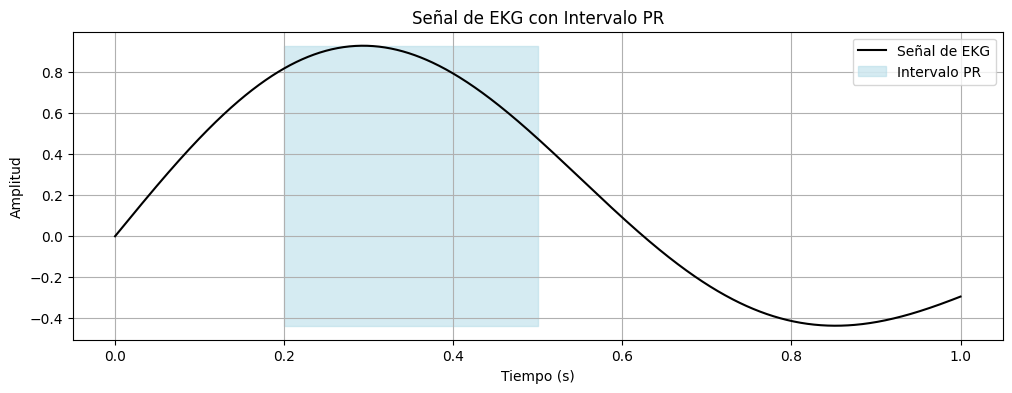

Posible bloqueo auriculoventricular: intervalo PR largo.


In [88]:
sistema = SistemaGestionModelo()


diagnostico = sistema.diagnosticar_paciente(fs, f_p, f_qrs, pr_interval_start, pr_interval_end)
print(diagnostico)


In [89]:
print("Diagnóstico del paciente: {}".format(diagnostico))

Diagnóstico del paciente: Posible bloqueo auriculoventricular: intervalo PR largo.


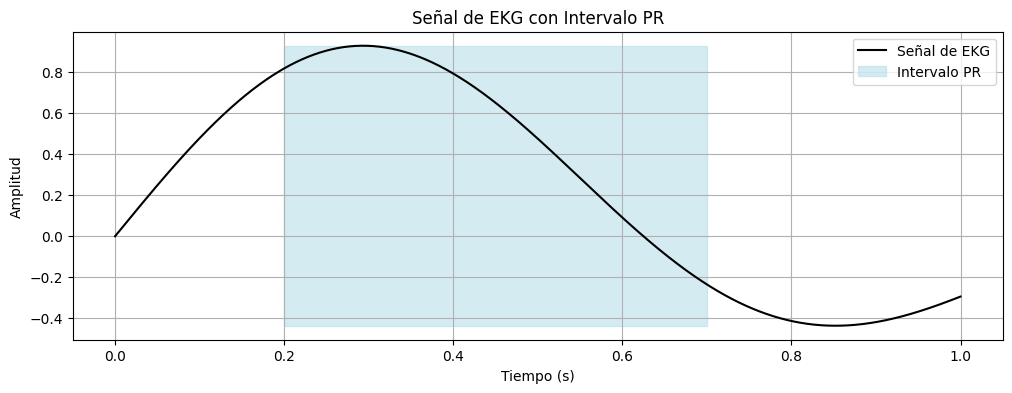

Diagnóstico del paciente: Bloqueo tipo I


In [93]:
pr_interval_start = 0.2  # Inicio del intervalo PR en segundos
pr_interval_end = 0.7  # Fin del intervalo PR en segundos

# Generar y mostrar la señal de EKG simulada
ecg_signal, pr_start, pr_end = sistema.cargar_ekg(fs, f_p, f_qrs, pr_interval_start, pr_interval_end)
print("Diagnóstico del paciente: {}".format(diagnostico))

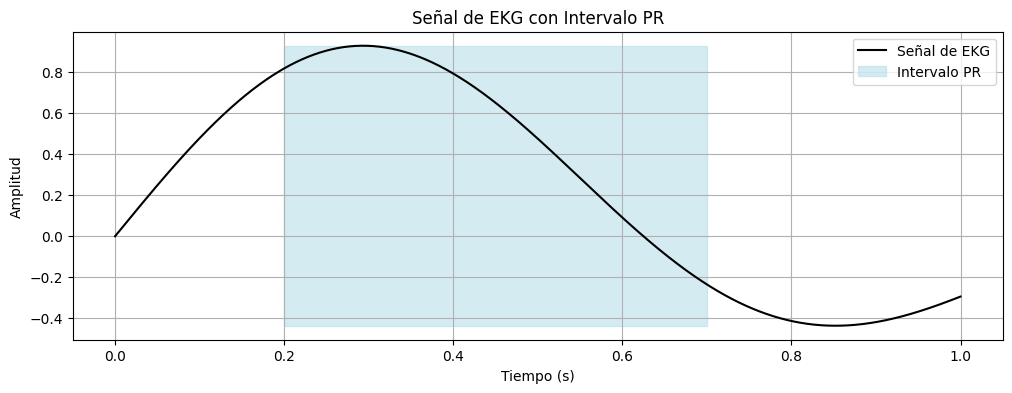

In [97]:
sistema = SistemaGestionModelo()
ecg_signal, pr_start, pr_end = sistema.cargar_ekg(fs, f_p, f_qrs, pr_interval_start, pr_interval_end)
# Variar la amplitud de la señal
factor_amplitud = 2
ecg_signal_variada = sistema.variar_amplitud_ekg(ecg_signal, factor_amplitud)


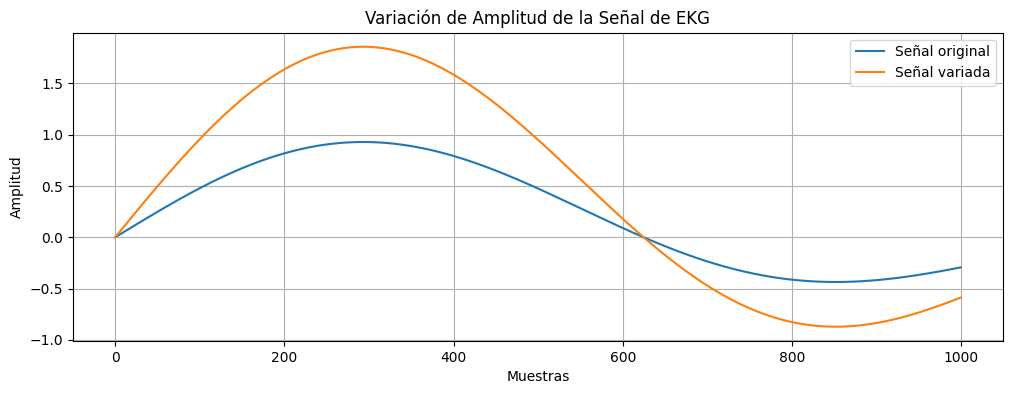

In [98]:
# Graficar la señal original y la señal variada
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal, label='Señal original')
plt.plot(ecg_signal_variada, label='Señal variada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Variación de Amplitud de la Señal de EKG')
plt.legend()
plt.grid(True)
plt.show()

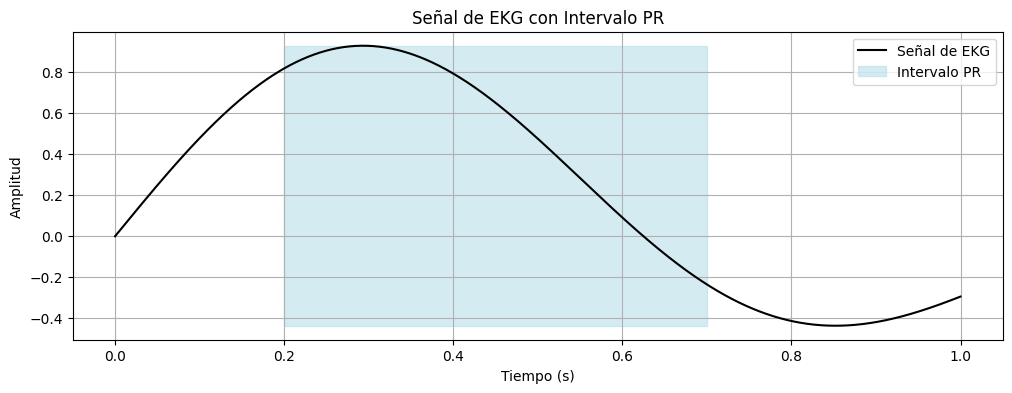

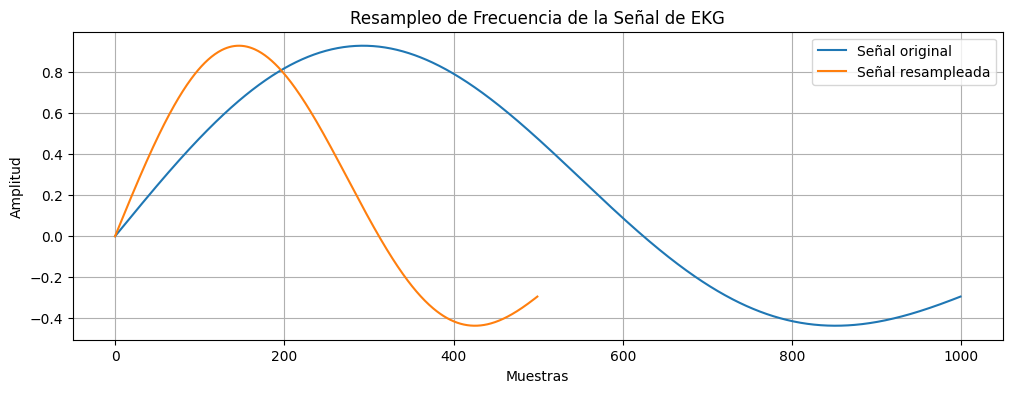

In [99]:

ecg_signal, pr_start, pr_end = sistema.cargar_ekg(fs, f_p, f_qrs, pr_interval_start, pr_interval_end)

# Variar la frecuencia de la señal
factor_frecuencia = 0.5
ecg_signal_resampleada = sistema.variar_frec_ekg(ecg_signal, factor_frecuencia)

# Graficar la señal original y la señal resampleada
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal, label='Señal original')
plt.plot(ecg_signal_resampleada, label='Señal resampleada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Resampleo de Frecuencia de la Señal de EKG')
plt.legend()
plt.grid(True)
plt.show()